In [30]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as  sns
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [12]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

In [13]:
genetic_selected_names = ['ptt_min','inr_max','calcium_min.1','temperature_mean','glucose_min','glucose_mean','weight_admit','aniongap_max','aniongap_min','potassium_min.1','bicarbonate_max.1','chloride_max.1','gcs_verbal','hemoglobin_min.1','hematocrit_min.1','bun_max','gcs_eyes','resp_rate_max','resp_rate_min','spo2_mean','spo2_min','dbp_min','sbp_mean','sbp_min','heart_rate_max','heart_rate_mean','race','admission_age']
genetic_selected_names.append('aki')
train = train.loc[:, genetic_selected_names]
test = test.loc[:, genetic_selected_names]

## Easy try

In [9]:
y = train['aki'].astype(float)
X = train.drop(['aki'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [11]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)


DecisionTreeClassifier()

In [12]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.3537984496124031


## Adjust Parameters

### Draw parameters with the Accurancy 2D curve to select the appropriate interval

In [14]:
y_train = train['aki'].astype(float)
X_train = train.drop(['aki'], axis=1)
y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)

def train_model_get_accuracy(X_train, y_train, parameters): 
    rf = DecisionTreeClassifier(
        criterion = parameters['criterion'],
        splitter = parameters['splitter'],
        max_depth = parameters['max_depth'],
        min_samples_split = parameters['min_samples_split'],
        min_samples_leaf = parameters['min_samples_leaf'],
        min_weight_fraction_leaf = parameters['min_weight_fraction_leaf'],
        max_features = parameters['max_features'],
        class_weight = parameters['class_weight'],
    )
    rf.fit(X_train, y_train)
    return accuracy_score(y_test,rf.predict(X_test))

def search_hyperparameter(param_name, search_arr, plot_arr, X_train, y_train):
    parameters = {       
        'criterion':'gini',
        'splitter':'best',
        'max_depth':None,
        'min_samples_split':2,
        'min_samples_leaf':1,
        'min_weight_fraction_leaf':0.0,
        'max_features':None,
        'class_weight':None,
    }
    accurancyList = {
        'params':[],
        'precision':[]
    }
    for n in search_arr:
        parameters[param_name] = n
        accurancyList['params'].append(parameters)
        accurancyList['precision'].append(train_model_get_accuracy(X_train, y_train, parameters))

    plt.plot(plot_arr, accurancyList['precision'])
    plt.xlabel(param_name)
    plt.ylabel('accurancy')
    plt.title(f'Accurancy {param_name}')
    plt.show()

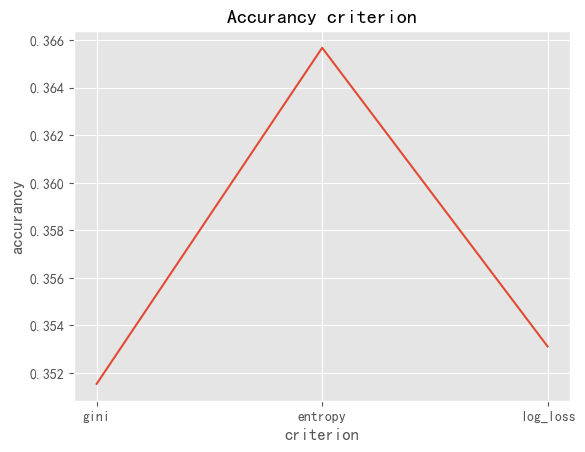

In [15]:
search_hyperparameter('criterion', 
                      ["gini", "entropy", "log_loss"], 
                      ["gini", "entropy", "log_loss"], 
                      X_train, 
                      y_train
                    )

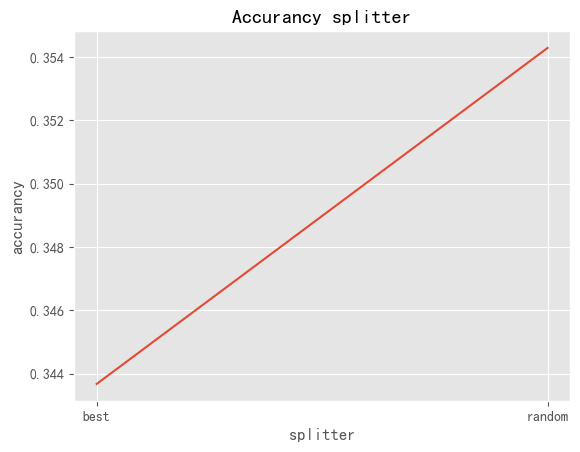

In [16]:
search_hyperparameter('splitter', 
                      ["best", "random"], 
                      ["best", "random"], 
                      X_train, 
                      y_train
                    )

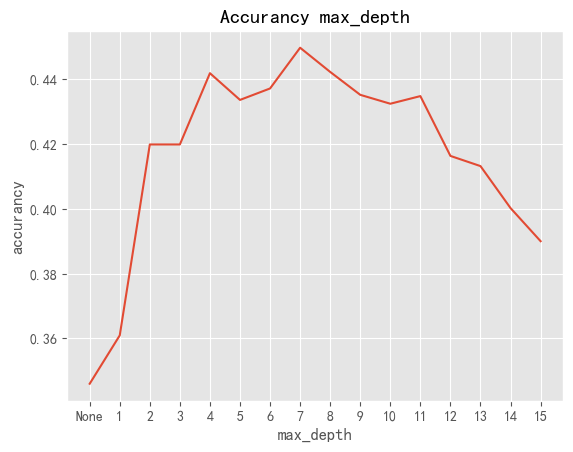

In [17]:
search_hyperparameter('max_depth', 
                      [None, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
                      [str(i) for i in[None, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]], 
                      X_train, 
                      y_train
                    )

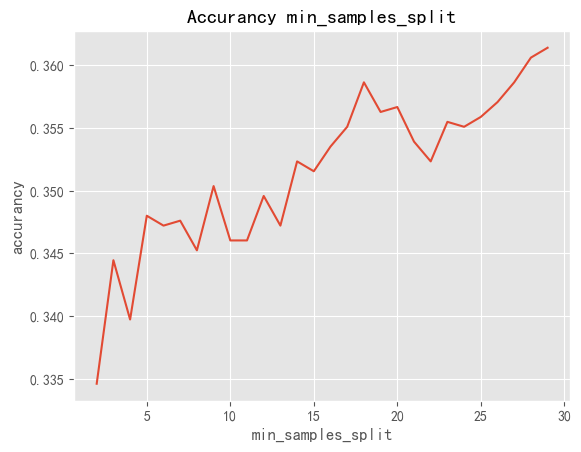

In [18]:
search_hyperparameter('min_samples_split', 
                      [*range(2,30)], 
                      [*range(2,30)], 
                      X_train, 
                      y_train
                    )

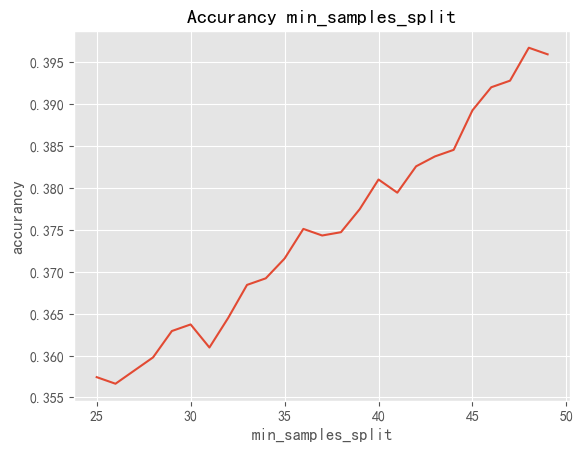

In [23]:
search_hyperparameter('min_samples_split', 
                      [*range(25, 50)], 
                      [*range(25, 50)], 
                      X_train, 
                      y_train
                    )

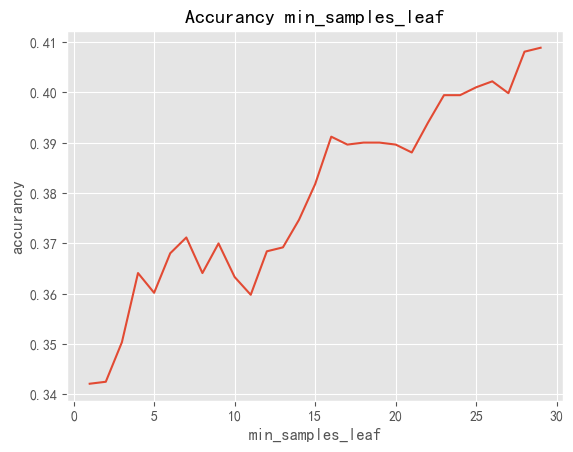

In [19]:
search_hyperparameter('min_samples_leaf', 
                      [*range(1,30)], 
                      [*range(1,30)], 
                      X_train, 
                      y_train
                    )

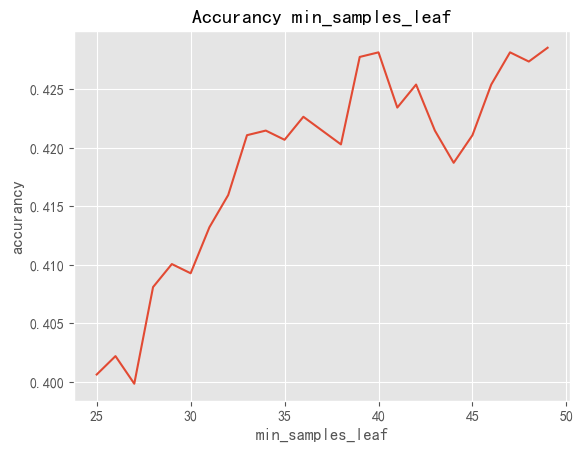

In [24]:
search_hyperparameter('min_samples_leaf', 
                      [*range(25, 50)], 
                      [*range(25, 50)], 
                      X_train, 
                      y_train
                    )

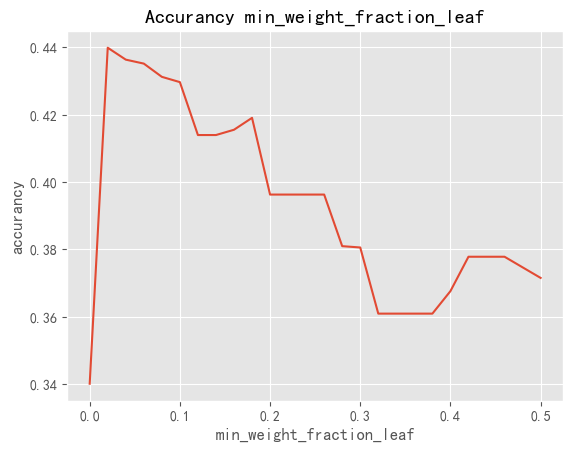

In [20]:
search_hyperparameter('min_weight_fraction_leaf', 
                      np.arange(0, 0.51, 0.02), 
                      np.arange(0, 0.51, 0.02), 
                      X_train, 
                      y_train
                    )

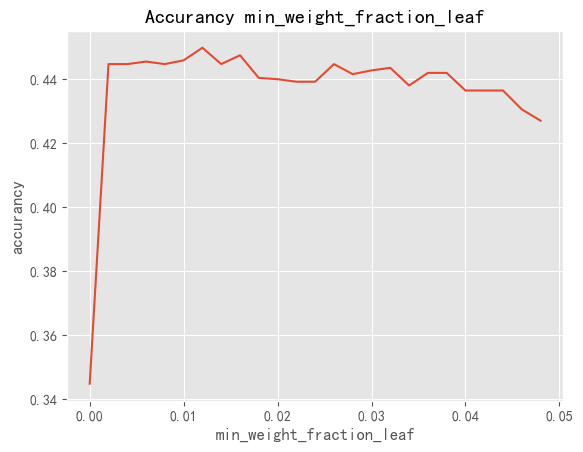

In [25]:
search_hyperparameter('min_weight_fraction_leaf', 
                      np.arange(0, 0.05, 0.002), 
                      np.arange(0, 0.05, 0.002), 
                      X_train, 
                      y_train
                    )

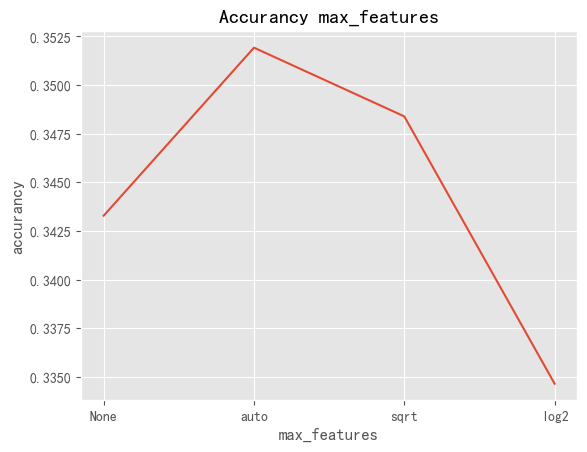

In [21]:
search_hyperparameter('max_features', 
                      [None, "auto", "sqrt", "log2"], 
                      ["None", "auto", "sqrt", "log2"], 
                      X_train, 
                      y_train
                    )

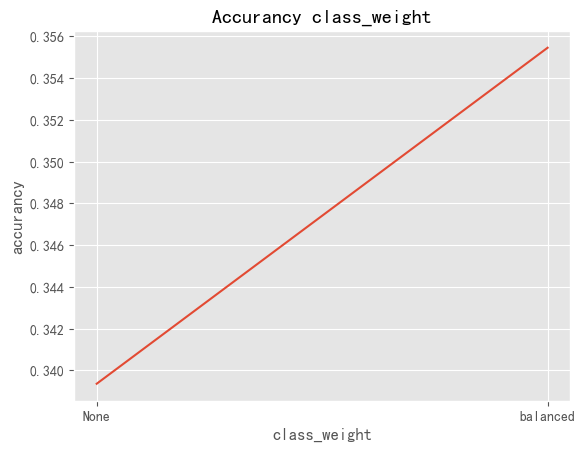

In [22]:
search_hyperparameter('class_weight', 
                      [None, "balanced"], 
                      ["None", "balanced"], 
                      X_train, 
                      y_train
                    )

### RandomizedSearch

In [28]:
param_dist = {
    "max_depth": [4,5,6,7,8,9,10],
    "min_samples_split": [*range(47,55)],
    "min_samples_leaf": [38, 39, 40, 41],
    "min_weight_fraction_leaf": np.arange(0.01, 0.016, 0.001),
}
model = DecisionTreeClassifier(criterion="entropy", splitter="random", max_features="auto", class_weight="balanced")
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="accuracy", cv=5, n_iter=10)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("DecisionTree AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

best_params {'min_weight_fraction_leaf': 0.011999999999999999, 'min_samples_split': 54, 'min_samples_leaf': 38, 'max_depth': 5}
best_score 0.3598422132581591
------------------------------------------------------------------
DecisionTree AUC (Macro): 0.5870718703562096
              precision    recall  f1-score   support

         0.0       0.39      0.79      0.52       808
         1.0       0.00      0.00      0.00       461
         2.0       0.42      0.23      0.29       837
         3.0       0.33      0.35      0.34       440

    accuracy                           0.38      2546
   macro avg       0.28      0.34      0.29      2546
weighted avg       0.32      0.38      0.32      2546

------------------------------------------------------------------
train accuracy: 0.3803282755199074, test accuracy: 0.384917517674784


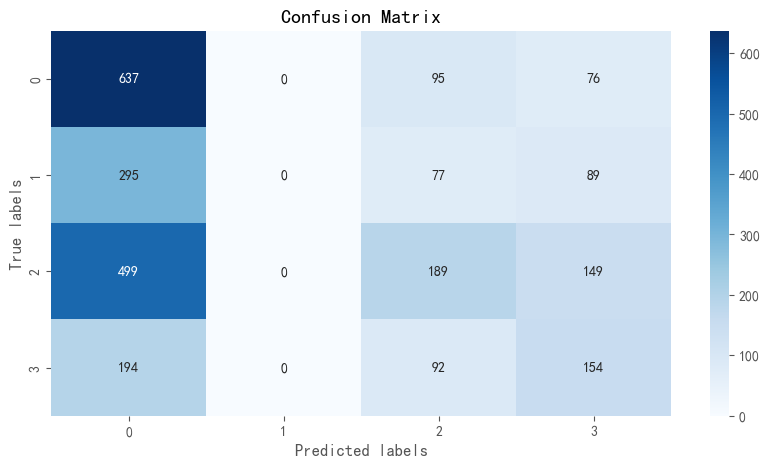

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()